In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf

from src.DataPreprocessor.data_preprocessor import DataPreprocessor, Mode
from src.LearningKeras.net_architecture import cnn_150x150x5
from src.LearningKeras.train import KerasTrainer

from tqdm import trange

np.random.seed(1)
tf.set_random_seed(2)

## Data

In [2]:
from src.DataPreprocessor.DataIOBackend.gdal_backend import GdalBackend
from src.DataPreprocessor.data_visualiser import DataVisualiser

dataiobackend = GdalBackend()
data_preprocessor = DataPreprocessor(data_dir="data/Region 1 - Lopukangri/",
                              backend=dataiobackend,
                              filename_prefix="tibet",
                              mode=Mode.TRAIN,
                              seed=1)

data_visualiser = DataVisualiser(data_preprocessor)

Driver: GTiff/GeoTIFF
Size is 3334 x 3335 x 1
Projection is PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]
Origin = (199970.0, 3400020.0)
Pixel Size = (30.0, -30.0)


#### RGB optical image with mask of labelled areas:
* red - faults
* green - fault lookalikes - "features that we think share visual or topographic similarity with faults, but expert interpretation can exclude"
* blue - not-faults - "areas that definitely do not include faults, nor things that we think even look like faults, can be used directly for training what faults are not."
 

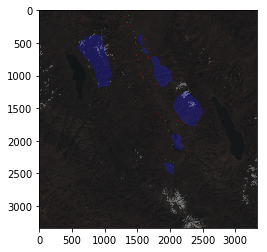

In [3]:
plt.imshow(data_visualiser.get_optical_rgb_with_features_mask())

Other images that we not used for training yet: 
    

#### Elevation

elevation map (from the Shuttle Radar Topography Mission), values in meters above sea level

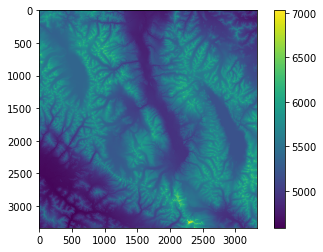

In [4]:
plt.imshow(data_preprocessor.elevation)
plt.colorbar()

/home/olga/VirtualEnv/VirtualEnv3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


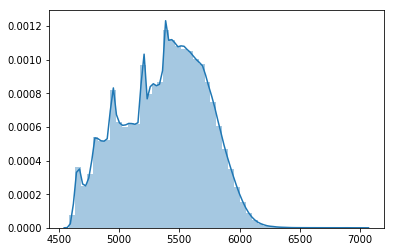

In [5]:
sns.distplot(data_preprocessor.elevation.flatten())

#### Slope

slope map derived from the elevation, values in degrees from horizontal, 0-90

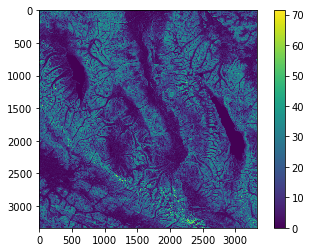

In [6]:
plt.imshow(data_preprocessor.slope)
plt.colorbar()

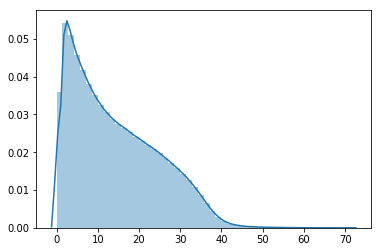

In [7]:
sns.distplot(data_preprocessor.slope.flatten())

### Normalisation

In [3]:
data_preprocessor.normalise()

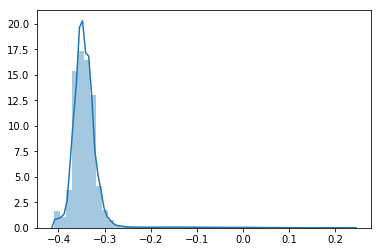

In [9]:
sns.distplot(data_preprocessor.optical_rgb[:, :, 0].flatten())

In [ ]:
sns.distplot(data_preprocessor.optical_rgb[:, :, 1].flatten())

In [ ]:
sns.distplot(data_preprocessor.optical_rgb[:, :, 2].flatten())

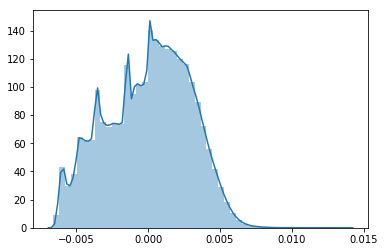

In [10]:
sns.distplot(data_preprocessor.elevation.flatten())

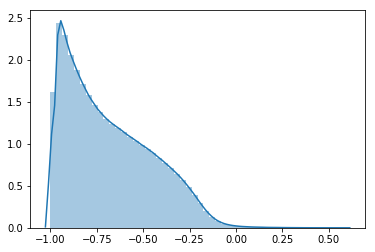

In [11]:
sns.distplot(data_preprocessor.slope.flatten())

### Examples of fault patches

In [7]:
num_patches = 7
patch_width = 150
patch_height = 150
bands = 5
patches = np.zeros((num_patches, patch_width, patch_height, bands))
for i in range(num_patches):
    patches[i] = data_preprocessor.sample_fault_patch()


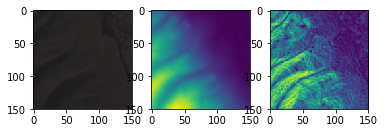

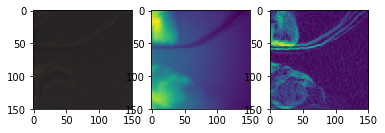

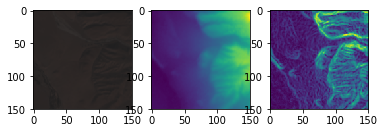

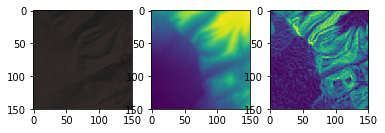

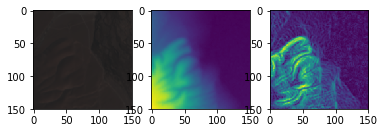

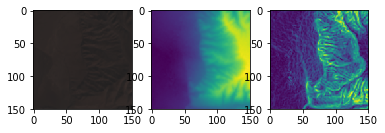

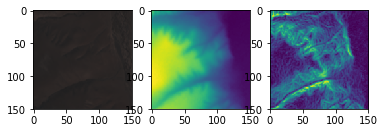

In [8]:
for i in range(num_patches):
    cur_patch = patches[i]
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(((cur_patch[:,:,:3]+0.5) * 255).astype(np.uint8))
    ax2.imshow((cur_patch[:,:,3]*data_preprocessor.elevation_var + data_preprocessor.elevation_mean))
    ax3.imshow((cur_patch[:,:,4]*45 + 45))
plt.show()

### Examples of nonfault patches

In [9]:
patches = np.zeros((num_patches, patch_width, patch_height, bands))
for i in range(num_patches):
    patches[i] = data_preprocessor.sample_nonfault_patch()

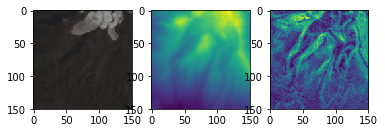

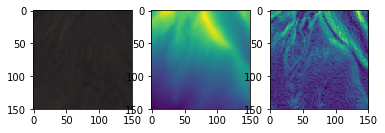

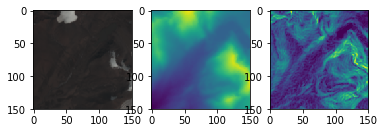

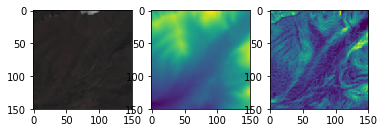

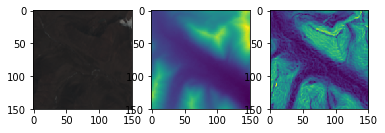

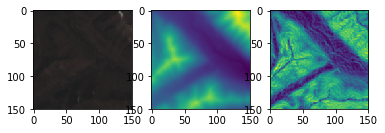

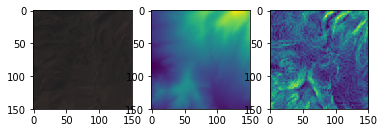

In [10]:
for i in range(num_patches):
    cur_patch = patches[i]
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(((cur_patch[:,:,:3]+0.5) * 255).astype(np.uint8))
    ax2.imshow((cur_patch[:,:,3]*data_preprocessor.elevation_var + data_preprocessor.elevation_mean))
    ax3.imshow((cur_patch[:,:,4]*45 + 45))
plt.show()

## NN

### Train

In [7]:
model_generator = lambda: cnn_150x150x5()
ensemble_size = 5
batch_size = 5

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size,
                       data_preprocessor=data_preprocessor,
                       batch_size=batch_size)

Epoch 1/5
50/50 [==============================] - 74s 1s/step - loss: 0.5439 - acc: 0.7160 - val_loss: 0.4368 - val_acc: 0.8000
Epoch 2/5
50/50 [==============================] - 70s 1s/step - loss: 0.4153 - acc: 0.7760 - val_loss: 0.1918 - val_acc: 0.9200
Epoch 3/5
50/50 [==============================] - 71s 1s/step - loss: 0.2588 - acc: 0.8800 - val_loss: 0.0901 - val_acc: 0.9600
Epoch 4/5
50/50 [==============================] - 70s 1s/step - loss: 0.1271 - acc: 0.9680 - val_loss: 0.0302 - val_acc: 1.0000
Epoch 5/5
50/50 [==============================] - 70s 1s/step - loss: 0.0619 - acc: 0.9840 - val_loss: 0.0950 - val_acc: 0.9200


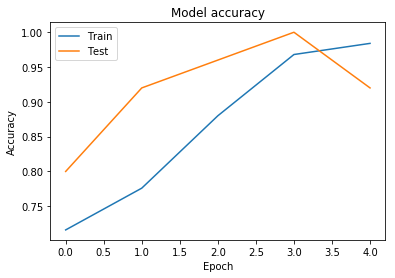

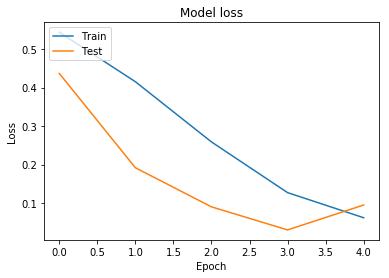

Epoch 1/5
50/50 [==============================] - 77s 2s/step - loss: 0.6842 - acc: 0.6360 - val_loss: 0.3053 - val_acc: 0.8800
Epoch 2/5
50/50 [==============================] - 73s 1s/step - loss: 0.3707 - acc: 0.8160 - val_loss: 0.2780 - val_acc: 0.9200
Epoch 3/5
50/50 [==============================] - 72s 1s/step - loss: 0.3437 - acc: 0.8480 - val_loss: 0.1529 - val_acc: 0.9200
Epoch 4/5
50/50 [==============================] - 70s 1s/step - loss: 0.2588 - acc: 0.8800 - val_loss: 0.1866 - val_acc: 0.9200
Epoch 5/5
50/50 [==============================] - 71s 1s/step - loss: 0.2240 - acc: 0.9200 - val_loss: 0.2984 - val_acc: 0.8800


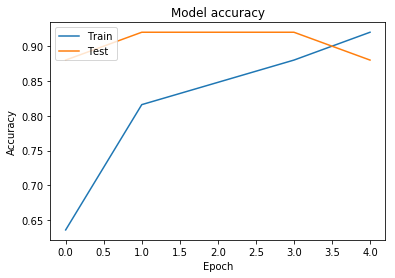

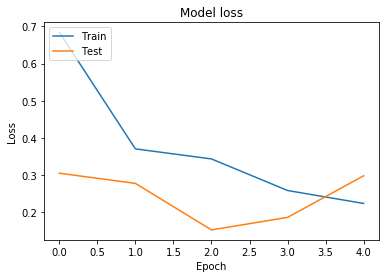

Epoch 1/5
50/50 [==============================] - 83s 2s/step - loss: 0.6533 - acc: 0.7200 - val_loss: 0.7649 - val_acc: 0.6400
Epoch 2/5
50/50 [==============================] - 76s 2s/step - loss: 0.3347 - acc: 0.8680 - val_loss: 0.2470 - val_acc: 0.8800
Epoch 3/5
50/50 [==============================] - 73s 1s/step - loss: 0.2114 - acc: 0.9200 - val_loss: 0.0427 - val_acc: 1.0000
Epoch 4/5
50/50 [==============================] - 78s 2s/step - loss: 0.1203 - acc: 0.9520 - val_loss: 0.0165 - val_acc: 1.0000
Epoch 5/5
50/50 [==============================] - 75s 2s/step - loss: 0.1021 - acc: 0.9680 - val_loss: 0.0105 - val_acc: 1.0000


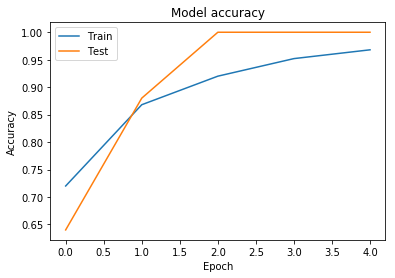

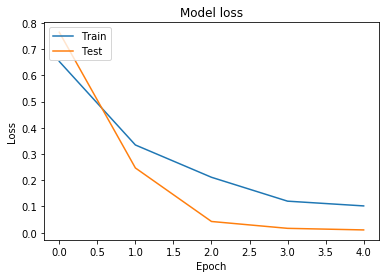

Epoch 1/5
50/50 [==============================] - 85s 2s/step - loss: 0.5462 - acc: 0.7360 - val_loss: 0.3005 - val_acc: 0.9600
Epoch 2/5
50/50 [==============================] - 79s 2s/step - loss: 0.2321 - acc: 0.9000 - val_loss: 0.1503 - val_acc: 0.9600
Epoch 3/5
50/50 [==============================] - 79s 2s/step - loss: 0.1467 - acc: 0.9360 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 4/5
50/50 [==============================] - 70s 1s/step - loss: 0.0643 - acc: 0.9840 - val_loss: 0.0865 - val_acc: 0.9600
Epoch 5/5
50/50 [==============================] - 70s 1s/step - loss: 0.0653 - acc: 0.9880 - val_loss: 0.0240 - val_acc: 1.0000


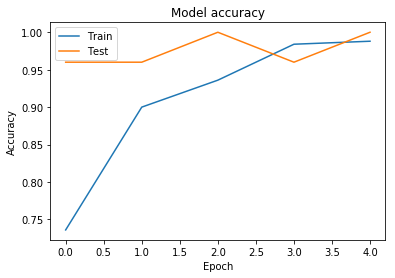

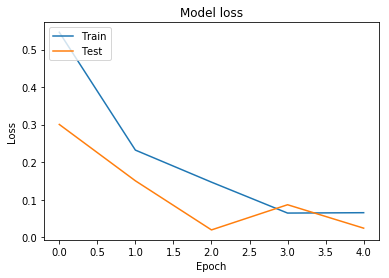

Epoch 1/5
50/50 [==============================] - 129s 3s/step - loss: 0.6246 - acc: 0.6960 - val_loss: 0.3009 - val_acc: 0.8800
Epoch 2/5
50/50 [==============================] - 92s 2s/step - loss: 0.4080 - acc: 0.8160 - val_loss: 0.1947 - val_acc: 0.9200
Epoch 3/5
50/50 [==============================] - 104s 2s/step - loss: 0.3400 - acc: 0.8160 - val_loss: 0.3271 - val_acc: 0.8800
Epoch 4/5
50/50 [==============================] - 71s 1s/step - loss: 0.2108 - acc: 0.9000 - val_loss: 0.1356 - val_acc: 0.9600
Epoch 5/5
50/50 [==============================] - 70s 1s/step - loss: 0.2218 - acc: 0.9120 - val_loss: 0.2576 - val_acc: 0.8400


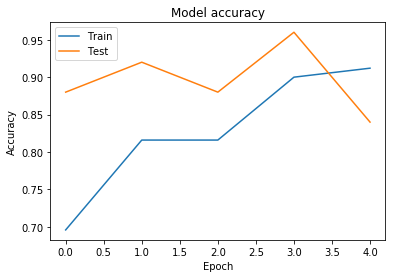

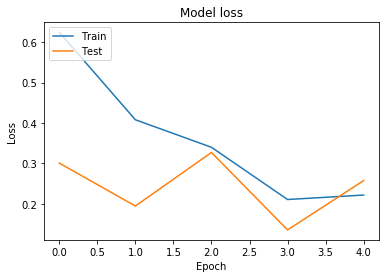

In [32]:
trainer.train(steps_per_epoch=50, epochs=5)

In [6]:
prediction_masks = trainer.apply_for_all_patches()

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 16.68it/s]
5it [00:00, 19.36it/s]
8it [00:00, 20.30it/s]
11it [00:00, 20.96it/s]
14it [00:00, 21.22it/s]
17it [00:00, 21.46it/s]
20it [00:00, 21.60it/s]
23it [00:01, 21.72it/s]
26it [00:01, 21.58it/s]
29it [00:01, 21.18it/s]
32it [00:01, 20.97it/s]
35it [00:01, 21.10it/s]
38it [00:01, 21.21it/s]
41it [00:01, 21.30it/s]
44it [00:02, 21.39it/s]
47it [00:02, 21.47it/s]
50it [00:02, 21.52it/s]
53it [00:02, 21.60it/s]
56it [00:02, 21.43it/s]
59it [00:02, 21.29it/s]
62it [00:02, 21.28it/s]
65it [00:03, 21.35it/s]
68it [00:03, 21.39it/s]
71it [00:03, 21.42it/s]
74it [00:03, 21.44it/s]
77it [00:03, 21.49it/s]
80it [00:03, 21.52it/s]
83it [00:03, 21.54it/s]
86it [00:03, 21.56it/s]
89it [00:04, 21.58it/s]
92it [00:04, 21.61it/s]
95it [00:04, 21.52it/s]
98it [00:04, 21.46it/s]
101it [00:04, 21.41it/s]
104it [00:04, 21.44it/s]
107it [00:04, 21.45it/s]
110it [00:05, 21.49it/s]
113it [00:05, 21.50it/s]
116it [00:05, 21.51it/s]
119i

386it [00:16, 22.73it/s]
389it [00:17, 22.74it/s]
392it [00:17, 22.75it/s]
395it [00:17, 22.75it/s]
398it [00:17, 22.76it/s]
401it [00:17, 22.77it/s]
404it [00:17, 22.78it/s]
407it [00:17, 22.78it/s]
410it [00:17, 22.79it/s]
413it [00:18, 22.78it/s]
416it [00:18, 22.76it/s]
419it [00:18, 22.74it/s]
422it [00:18, 22.73it/s]
425it [00:18, 22.72it/s]
428it [00:18, 22.72it/s]
431it [00:18, 22.72it/s]
434it [00:19, 22.73it/s]
437it [00:19, 22.73it/s]
440it [00:19, 22.73it/s]
443it [00:19, 22.74it/s]
446it [00:19, 22.74it/s]
449it [00:19, 22.73it/s]
452it [00:19, 22.74it/s]
455it [00:20, 22.74it/s]
458it [00:20, 22.74it/s]
461it [00:20, 22.75it/s]
464it [00:20, 22.74it/s]
467it [00:20, 22.75it/s]
470it [00:20, 22.75it/s]
473it [00:20, 22.75it/s]
476it [00:20, 22.76it/s]
479it [00:21, 22.76it/s]
482it [00:21, 22.77it/s]
 40%|████      | 2/5 [00:46<01:09, 23.01s/it]
0it [00:00, ?it/s]
2it [00:00, 13.62it/s]
5it [00:00, 17.54it/s]
7it [00:00, 17.79it/s]
9it [00:00, 17.38it/s]
11it [00:00, 17.08

266it [00:11, 23.68it/s]
269it [00:11, 23.69it/s]
272it [00:11, 23.69it/s]
275it [00:11, 23.69it/s]
278it [00:11, 23.69it/s]
281it [00:11, 23.69it/s]
284it [00:11, 23.69it/s]
287it [00:12, 23.70it/s]
290it [00:12, 23.70it/s]
293it [00:12, 23.70it/s]
296it [00:12, 23.70it/s]
299it [00:12, 23.70it/s]
302it [00:12, 23.71it/s]
305it [00:12, 23.70it/s]
308it [00:12, 23.70it/s]
311it [00:13, 23.71it/s]
314it [00:13, 23.71it/s]
317it [00:13, 23.71it/s]
320it [00:13, 23.71it/s]
323it [00:13, 23.71it/s]
326it [00:13, 23.71it/s]
329it [00:13, 23.71it/s]
332it [00:14, 23.71it/s]
335it [00:14, 23.71it/s]
338it [00:14, 23.71it/s]
341it [00:14, 23.71it/s]
344it [00:14, 23.72it/s]
347it [00:14, 23.72it/s]
350it [00:14, 23.72it/s]
353it [00:14, 23.72it/s]
356it [00:15, 23.73it/s]
359it [00:15, 23.72it/s]
362it [00:15, 23.73it/s]
365it [00:15, 23.73it/s]
368it [00:15, 23.73it/s]
371it [00:15, 23.73it/s]
374it [00:15, 23.73it/s]
377it [00:15, 23.73it/s]
380it [00:16, 23.73it/s]
383it [00:16, 23.73it/s]


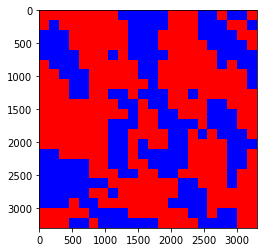

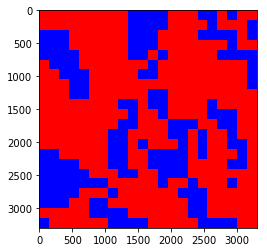

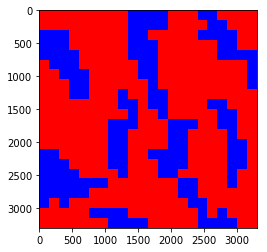

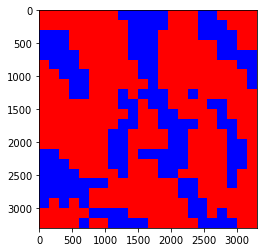

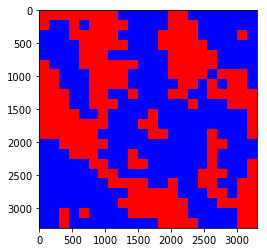

In [7]:
for i in range(prediction_masks.shape[0]):
    plt.figure()
    plt.imshow(prediction_masks[i])
plt.show()

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


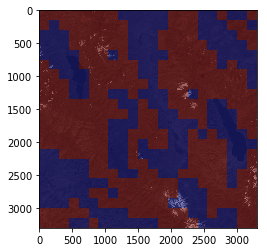

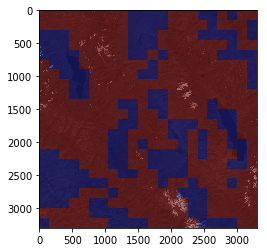

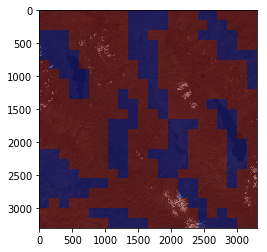

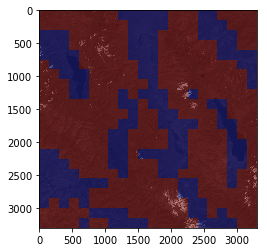

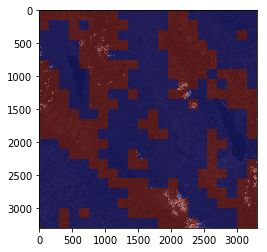

In [31]:
#images = np.zeros((ensemble_size, 3300, 3300, 4))
for en in trange(ensemble_size):
    mask_np = np.array(Image.fromarray(prediction_masks[en].astype(np.uint8)).convert('RGBA'))
    mask_np[:, :, 3] = 60 * np.ones((22 * 150, 22 * 150))
    mask_a = Image.fromarray(mask_np)
    orig = Image.fromarray(data_preprocessor.original_optical_rgb).convert('RGBA')
    orig_c = orig.crop((0, 0, 22 * 150, 22 * 150))
    im_comp = Image.alpha_composite(orig_c, mask_a)
    n_im_comp = np.array(im_comp)
    plt.figure()
    plt.imshow(np.array(im_comp))
plt.show()

In [23]:
# for i in range(images.shape[0]):
#     plt.figure()
#     im = Image.fromarray(images[i].astype(np.uint8))
#     im.show()
# plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
res = trainer.apply_for_sliding_window(data_preprocessor, stride=10, max_output_size=50)

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 17.89it/s]
5it [00:00, 19.97it/s]
8it [00:00, 21.05it/s]
11it [00:00, 21.36it/s]
14it [00:00, 21.67it/s]
17it [00:00, 21.72it/s]
19it [00:00, 21.46it/s]
22it [00:01, 21.60it/s]
25it [00:01, 21.79it/s]
28it [00:01, 21.73it/s]
31it [00:01, 21.89it/s]
34it [00:01, 21.97it/s]
37it [00:01, 22.07it/s]
40it [00:01, 22.13it/s]
43it [00:01, 22.22it/s]
46it [00:02, 22.20it/s]
49it [00:02, 22.24it/s]
52it [00:02, 22.13it/s]
55it [00:02, 22.15it/s]
58it [00:02, 22.16it/s]
61it [00:02, 22.23it/s]
64it [00:02, 22.08it/s]
67it [00:03, 22.07it/s]
70it [00:03, 22.14it/s]
73it [00:03, 22.07it/s]
76it [00:03, 22.00it/s]
79it [00:03, 21.98it/s]
82it [00:03, 22.03it/s]
85it [00:03, 22.03it/s]
88it [00:03, 22.05it/s]
91it [00:04, 22.08it/s]
94it [00:04, 22.09it/s]
97it [00:04, 22.13it/s]
100it [00:04, 22.12it/s]
103it [00:04, 22.16it/s]
106it [00:04, 22.17it/s]
109it [00:04, 22.15it/s]
112it [00:05, 22.18it/s]
115it [00:05, 22.20it/s]
118i

874it [00:37, 23.20it/s]
877it [00:37, 23.20it/s]
880it [00:37, 23.19it/s]
883it [00:38, 23.19it/s]
886it [00:38, 23.19it/s]
889it [00:38, 23.19it/s]
892it [00:38, 23.20it/s]
895it [00:38, 23.20it/s]
898it [00:38, 23.20it/s]
901it [00:38, 23.20it/s]
904it [00:38, 23.20it/s]
907it [00:39, 23.20it/s]
910it [00:39, 23.21it/s]
913it [00:39, 23.21it/s]
916it [00:39, 23.21it/s]
919it [00:39, 23.21it/s]
922it [00:39, 23.21it/s]
925it [00:39, 23.22it/s]
928it [00:39, 23.22it/s]
931it [00:40, 23.22it/s]
934it [00:40, 23.22it/s]
937it [00:40, 23.22it/s]
940it [00:40, 23.23it/s]
943it [00:40, 23.23it/s]
946it [00:40, 23.23it/s]
949it [00:40, 23.23it/s]
952it [00:40, 23.23it/s]
955it [00:41, 23.23it/s]
958it [00:41, 23.23it/s]
961it [00:41, 23.24it/s]
964it [00:41, 23.24it/s]
967it [00:41, 23.24it/s]
970it [00:41, 23.24it/s]
973it [00:41, 23.24it/s]
976it [00:41, 23.24it/s]
979it [00:42, 23.24it/s]
982it [00:42, 23.25it/s]
985it [00:42, 23.25it/s]
988it [00:42, 23.25it/s]
991it [00:42, 23.25it/s]


box: [[2800, 2100, 2950, 2250]]
box: [[2900, 2200, 3050, 2350]]
box: [[2400, 200, 2550, 350]]
box: [[2500, 200, 2650, 350]]
box: [[2700, 2100, 2850, 2250]]
box: [[2400, 100, 2550, 250]]
box: [[2300, 0, 2450, 150]]
box: [[2200, 0, 2350, 150]]
box: [[2500, 400, 2650, 550]]
box: [[1200, 2200, 1350, 2350]]
box: [[2300, 100, 2450, 250]]
box: [[0, 1500, 150, 1650]]
box: [[200, 1400, 350, 1550]]
box: [[2500, 100, 2650, 250]]
box: [[2500, 300, 2650, 450]]
box: [[2400, 0, 2550, 150]]
box: [[0, 1400, 150, 1550]]
box: [[2600, 200, 2750, 350]]
box: [[2200, 100, 2350, 250]]
box: [[0, 1600, 150, 1750]]
box: [[100, 1400, 250, 1550]]
box: [[200, 1500, 350, 1650]]
box: [[100, 1500, 250, 1650]]
box: [[2300, 200, 2450, 350]]
box: [[2200, 2100, 2350, 2250]]
box: [[2400, 300, 2550, 450]]
box: [[2600, 100, 2750, 250]]
box: [[2200, 2000, 2350, 2150]]
box: [[100, 1600, 250, 1750]]
box: [[1300, 1700, 1450, 1850]]
box: [[0, 1700, 150, 1850]]
box: [[400, 200, 550, 350]]
box: [[1700, 2000, 1850, 2150]]
box: [[300

 20%|██        | 1/5 [00:45<03:02, 45.73s/it]
0it [00:00, ?it/s]
2it [00:00, 18.93it/s]
5it [00:00, 21.59it/s]
8it [00:00, 22.24it/s]
11it [00:00, 22.70it/s]
14it [00:00, 22.95it/s]
17it [00:00, 23.02it/s]
20it [00:00, 23.17it/s]
23it [00:00, 23.27it/s]
26it [00:01, 23.35it/s]
29it [00:01, 23.44it/s]
32it [00:01, 23.45it/s]
35it [00:01, 23.48it/s]
38it [00:01, 23.54it/s]
41it [00:01, 23.51it/s]
44it [00:01, 23.54it/s]
47it [00:01, 23.59it/s]
50it [00:02, 23.62it/s]
53it [00:02, 23.62it/s]
56it [00:02, 23.63it/s]
59it [00:02, 23.65it/s]
62it [00:02, 23.66it/s]
65it [00:02, 23.70it/s]
68it [00:02, 23.71it/s]
71it [00:02, 23.72it/s]
74it [00:03, 23.73it/s]
77it [00:03, 23.70it/s]
80it [00:03, 23.70it/s]
83it [00:03, 23.69it/s]
86it [00:03, 23.71it/s]
89it [00:03, 23.70it/s]
92it [00:03, 23.72it/s]
95it [00:04, 23.74it/s]
98it [00:04, 23.73it/s]
101it [00:04, 23.72it/s]
104it [00:04, 23.72it/s]
107it [00:04, 23.73it/s]
110it [00:04, 23.73it/s]
113it [00:04, 23.72it/s]
116it [00:04, 23.73it

875it [00:36, 23.73it/s]
878it [00:36, 23.74it/s]
881it [00:37, 23.74it/s]
884it [00:37, 23.73it/s]
887it [00:37, 23.74it/s]
890it [00:37, 23.73it/s]
893it [00:37, 23.74it/s]
896it [00:37, 23.74it/s]
899it [00:37, 23.74it/s]
902it [00:37, 23.74it/s]
905it [00:38, 23.74it/s]
908it [00:38, 23.74it/s]
911it [00:38, 23.74it/s]
914it [00:38, 23.74it/s]
917it [00:38, 23.74it/s]
920it [00:38, 23.75it/s]
923it [00:38, 23.75it/s]
926it [00:38, 23.75it/s]
929it [00:39, 23.75it/s]
932it [00:39, 23.75it/s]
935it [00:39, 23.75it/s]
938it [00:39, 23.75it/s]
941it [00:39, 23.75it/s]
944it [00:39, 23.75it/s]
947it [00:39, 23.75it/s]
950it [00:39, 23.76it/s]
953it [00:40, 23.76it/s]
956it [00:40, 23.75it/s]
959it [00:40, 23.75it/s]
962it [00:40, 23.75it/s]
965it [00:40, 23.75it/s]
968it [00:40, 23.75it/s]
971it [00:40, 23.75it/s]
974it [00:41, 23.75it/s]
977it [00:41, 23.75it/s]
980it [00:41, 23.75it/s]
983it [00:41, 23.75it/s]
986it [00:41, 23.75it/s]
989it [00:41, 23.75it/s]
992it [00:41, 23.75it/s]


box: [[2600, 200, 2750, 350]]
box: [[2200, 2100, 2350, 2250]]
box: [[2400, 500, 2550, 650]]
box: [[2500, 400, 2650, 550]]
box: [[600, 1600, 750, 1750]]
box: [[2700, 2100, 2850, 2250]]
box: [[700, 1600, 850, 1750]]
box: [[300, 1500, 450, 1650]]
box: [[100, 1600, 250, 1750]]
box: [[3100, 2400, 3250, 2550]]
box: [[3100, 2800, 3250, 2950]]
box: [[2500, 200, 2650, 350]]
box: [[200, 1500, 350, 1650]]
box: [[2400, 200, 2550, 350]]
box: [[2300, 0, 2450, 150]]
box: [[2900, 2200, 3050, 2350]]
box: [[2200, 0, 2350, 150]]
box: [[2300, 100, 2450, 250]]
box: [[2400, 100, 2550, 250]]
box: [[0, 1500, 150, 1650]]
box: [[2300, 3000, 2450, 3150]]
box: [[0, 1600, 150, 1750]]
box: [[200, 1600, 350, 1750]]
box: [[400, 400, 550, 550]]
box: [[2400, 2000, 2550, 2150]]
box: [[0, 1900, 150, 2050]]
box: [[0, 1700, 150, 1850]]
box: [[2300, 2000, 2450, 2150]]
box: [[2400, 0, 2550, 150]]
box: [[700, 400, 850, 550]]
box: [[200, 1400, 350, 1550]]
box: [[0, 1400, 150, 1550]]
box: [[400, 200, 550, 350]]
box: [[2600, 800

 40%|████      | 2/5 [01:30<02:15, 45.31s/it]
0it [00:00, ?it/s]
2it [00:00, 16.56it/s]
5it [00:00, 20.22it/s]
8it [00:00, 21.48it/s]
11it [00:00, 21.90it/s]
14it [00:00, 22.29it/s]
17it [00:00, 22.58it/s]
20it [00:00, 22.83it/s]
23it [00:01, 22.96it/s]
26it [00:01, 23.12it/s]
29it [00:01, 23.24it/s]
32it [00:01, 23.32it/s]
35it [00:01, 23.38it/s]
38it [00:01, 23.45it/s]
41it [00:01, 23.45it/s]
44it [00:01, 23.51it/s]
47it [00:02, 23.46it/s]
50it [00:02, 23.49it/s]
53it [00:02, 23.52it/s]
56it [00:02, 23.56it/s]
59it [00:02, 23.59it/s]
62it [00:02, 23.60it/s]
65it [00:02, 23.63it/s]
68it [00:02, 23.66it/s]
71it [00:02, 23.68it/s]
74it [00:03, 23.69it/s]
77it [00:03, 23.71it/s]
80it [00:03, 23.74it/s]
83it [00:03, 23.73it/s]
86it [00:03, 23.72it/s]
89it [00:03, 23.72it/s]
92it [00:03, 23.73it/s]
95it [00:03, 23.75it/s]
98it [00:04, 23.77it/s]
101it [00:04, 23.77it/s]
104it [00:04, 23.77it/s]
107it [00:04, 23.79it/s]
110it [00:04, 23.79it/s]
113it [00:04, 23.81it/s]
116it [00:04, 23.80it

875it [00:36, 23.86it/s]
878it [00:36, 23.86it/s]
881it [00:36, 23.86it/s]
884it [00:37, 23.86it/s]
887it [00:37, 23.86it/s]
890it [00:37, 23.86it/s]
893it [00:37, 23.86it/s]
896it [00:37, 23.86it/s]
899it [00:37, 23.86it/s]
902it [00:37, 23.86it/s]
905it [00:37, 23.86it/s]
908it [00:38, 23.86it/s]
911it [00:38, 23.86it/s]
914it [00:38, 23.86it/s]
917it [00:38, 23.86it/s]
920it [00:38, 23.86it/s]
923it [00:38, 23.86it/s]
926it [00:38, 23.86it/s]
929it [00:38, 23.86it/s]
932it [00:39, 23.86it/s]
935it [00:39, 23.86it/s]
938it [00:39, 23.86it/s]
941it [00:39, 23.86it/s]
944it [00:39, 23.86it/s]
947it [00:39, 23.86it/s]
950it [00:39, 23.86it/s]
953it [00:39, 23.86it/s]
956it [00:40, 23.86it/s]
959it [00:40, 23.86it/s]
962it [00:40, 23.86it/s]
965it [00:40, 23.86it/s]
968it [00:40, 23.86it/s]
971it [00:40, 23.86it/s]
974it [00:40, 23.87it/s]
977it [00:40, 23.86it/s]
980it [00:41, 23.86it/s]
983it [00:41, 23.87it/s]
986it [00:41, 23.87it/s]
989it [00:41, 23.87it/s]
992it [00:41, 23.87it/s]


box: [[2400, 200, 2550, 350]]
box: [[2400, 100, 2550, 250]]
box: [[2500, 200, 2650, 350]]
box: [[2300, 0, 2450, 150]]
box: [[2200, 0, 2350, 150]]
box: [[2300, 100, 2450, 250]]
box: [[2500, 300, 2650, 450]]
box: [[2500, 100, 2650, 250]]
box: [[0, 1500, 150, 1650]]
box: [[2400, 0, 2550, 150]]
box: [[0, 1400, 150, 1550]]
box: [[2500, 400, 2650, 550]]
box: [[200, 1400, 350, 1550]]
box: [[2600, 200, 2750, 350]]
box: [[100, 1400, 250, 1550]]
box: [[2200, 100, 2350, 250]]
box: [[100, 1500, 250, 1650]]
box: [[200, 1500, 350, 1650]]
box: [[0, 1600, 150, 1750]]
box: [[2300, 200, 2450, 350]]
box: [[2400, 300, 2550, 450]]
box: [[1300, 1700, 1450, 1850]]
box: [[2600, 100, 2750, 250]]
box: [[2200, 2000, 2350, 2150]]
box: [[0, 1700, 150, 1850]]
box: [[2200, 2100, 2350, 2250]]
box: [[1800, 2000, 1950, 2150]]
box: [[300, 1400, 450, 1550]]
box: [[1700, 2000, 1850, 2150]]
box: [[400, 200, 550, 350]]
box: [[100, 1600, 250, 1750]]
box: [[2100, 0, 2250, 150]]
box: [[300, 1500, 450, 1650]]
box: [[2300, 2000,

 60%|██████    | 3/5 [02:15<01:30, 45.11s/it]
0it [00:00, ?it/s]
2it [00:00, 16.41it/s]
5it [00:00, 19.96it/s]
8it [00:00, 21.55it/s]
11it [00:00, 22.20it/s]
14it [00:00, 22.51it/s]
17it [00:00, 22.62it/s]
20it [00:00, 22.93it/s]
23it [00:00, 23.13it/s]
26it [00:01, 23.30it/s]
29it [00:01, 23.36it/s]
32it [00:01, 23.39it/s]
35it [00:01, 23.55it/s]
38it [00:01, 23.59it/s]
41it [00:01, 23.57it/s]
44it [00:01, 23.65it/s]
47it [00:01, 23.70it/s]
50it [00:02, 23.75it/s]
53it [00:02, 23.78it/s]
56it [00:02, 23.79it/s]
59it [00:02, 23.82it/s]
62it [00:02, 23.86it/s]
65it [00:02, 23.89it/s]
68it [00:02, 23.91it/s]
71it [00:02, 23.94it/s]
74it [00:03, 23.96it/s]
77it [00:03, 23.96it/s]
80it [00:03, 23.94it/s]
83it [00:03, 23.95it/s]
86it [00:03, 23.98it/s]
89it [00:03, 23.99it/s]
92it [00:03, 23.98it/s]
95it [00:03, 24.00it/s]
98it [00:04, 24.00it/s]
101it [00:04, 24.00it/s]
104it [00:04, 24.02it/s]
107it [00:04, 24.02it/s]
110it [00:04, 24.03it/s]
113it [00:04, 24.03it/s]
116it [00:04, 24.05it

875it [00:36, 24.13it/s]
878it [00:36, 24.13it/s]
881it [00:36, 24.13it/s]
884it [00:36, 24.13it/s]
887it [00:36, 24.13it/s]
890it [00:36, 24.13it/s]
893it [00:37, 24.13it/s]
896it [00:37, 24.13it/s]
899it [00:37, 24.13it/s]
902it [00:37, 24.13it/s]
905it [00:37, 24.13it/s]
908it [00:37, 24.13it/s]
911it [00:37, 24.13it/s]
914it [00:37, 24.14it/s]
917it [00:37, 24.13it/s]
920it [00:38, 24.14it/s]
923it [00:38, 24.14it/s]
926it [00:38, 24.14it/s]
929it [00:38, 24.14it/s]
932it [00:38, 24.14it/s]
935it [00:38, 24.14it/s]
938it [00:38, 24.14it/s]
941it [00:38, 24.14it/s]
944it [00:39, 24.14it/s]
947it [00:39, 24.15it/s]
950it [00:39, 24.15it/s]
953it [00:39, 24.15it/s]
956it [00:39, 24.15it/s]
959it [00:39, 24.15it/s]
962it [00:39, 24.15it/s]
965it [00:39, 24.15it/s]
968it [00:40, 24.15it/s]
971it [00:40, 24.15it/s]
974it [00:40, 24.15it/s]
977it [00:40, 24.15it/s]
980it [00:40, 24.15it/s]
983it [00:40, 24.15it/s]
986it [00:40, 24.15it/s]
989it [00:40, 24.15it/s]
992it [00:41, 24.15it/s]


box: [[2400, 200, 2550, 350]]
box: [[2500, 200, 2650, 350]]
box: [[2400, 100, 2550, 250]]
box: [[2300, 0, 2450, 150]]
box: [[2200, 0, 2350, 150]]
box: [[2500, 300, 2650, 450]]
box: [[2500, 100, 2650, 250]]
box: [[2300, 100, 2450, 250]]
box: [[0, 1500, 150, 1650]]
box: [[2500, 400, 2650, 550]]
box: [[2400, 0, 2550, 150]]
box: [[200, 1400, 350, 1550]]
box: [[2800, 2100, 2950, 2250]]
box: [[0, 1400, 150, 1550]]
box: [[2600, 200, 2750, 350]]
box: [[100, 1400, 250, 1550]]
box: [[0, 1600, 150, 1750]]
box: [[100, 1500, 250, 1650]]
box: [[200, 1500, 350, 1650]]
box: [[2200, 100, 2350, 250]]
box: [[2600, 100, 2750, 250]]
box: [[2200, 2100, 2350, 2250]]
box: [[0, 1700, 150, 1850]]
box: [[2300, 200, 2450, 350]]
box: [[1300, 1700, 1450, 1850]]
box: [[2200, 2000, 2350, 2150]]
box: [[2400, 300, 2550, 450]]
box: [[1700, 2000, 1850, 2150]]
box: [[100, 1600, 250, 1750]]
box: [[1800, 2000, 1950, 2150]]
box: [[300, 1400, 450, 1550]]
box: [[2700, 100, 2850, 250]]
box: [[2300, 2000, 2450, 2150]]
box: [[260

 80%|████████  | 4/5 [02:59<00:44, 44.87s/it]
0it [00:00, ?it/s]
2it [00:00, 15.29it/s]
5it [00:00, 19.40it/s]
8it [00:00, 20.80it/s]
11it [00:00, 21.47it/s]
14it [00:00, 21.92it/s]
17it [00:00, 22.16it/s]
20it [00:00, 22.39it/s]
23it [00:01, 22.65it/s]
26it [00:01, 22.81it/s]
29it [00:01, 22.94it/s]
32it [00:01, 23.04it/s]
35it [00:01, 23.15it/s]
38it [00:01, 23.25it/s]
41it [00:01, 23.27it/s]
44it [00:01, 23.33it/s]
47it [00:02, 23.39it/s]
50it [00:02, 23.41it/s]
53it [00:02, 23.44it/s]
56it [00:02, 23.45it/s]
59it [00:02, 23.47it/s]
62it [00:02, 23.49it/s]
65it [00:02, 23.51it/s]
68it [00:02, 23.57it/s]
71it [00:03, 23.57it/s]
74it [00:03, 23.55it/s]
77it [00:03, 23.55it/s]
80it [00:03, 23.55it/s]
83it [00:03, 23.55it/s]
86it [00:03, 23.55it/s]
89it [00:03, 23.58it/s]
92it [00:03, 23.58it/s]
95it [00:04, 23.60it/s]
98it [00:04, 23.61it/s]
101it [00:04, 23.62it/s]
104it [00:04, 23.64it/s]
107it [00:04, 23.66it/s]
110it [00:04, 23.65it/s]
113it [00:04, 23.67it/s]
116it [00:04, 23.67it

875it [00:36, 23.83it/s]
878it [00:36, 23.83it/s]
881it [00:36, 23.83it/s]
884it [00:37, 23.83it/s]
887it [00:37, 23.83it/s]
890it [00:37, 23.83it/s]
893it [00:37, 23.83it/s]
896it [00:37, 23.83it/s]
899it [00:37, 23.83it/s]
902it [00:37, 23.83it/s]
905it [00:37, 23.83it/s]
908it [00:38, 23.84it/s]
911it [00:38, 23.84it/s]
914it [00:38, 23.84it/s]
917it [00:38, 23.84it/s]
920it [00:38, 23.84it/s]
923it [00:38, 23.84it/s]
926it [00:38, 23.84it/s]
929it [00:38, 23.84it/s]
932it [00:39, 23.84it/s]
935it [00:39, 23.84it/s]
938it [00:39, 23.84it/s]
941it [00:39, 23.84it/s]
944it [00:39, 23.84it/s]
947it [00:39, 23.84it/s]
950it [00:39, 23.84it/s]
953it [00:39, 23.84it/s]
956it [00:40, 23.84it/s]
959it [00:40, 23.84it/s]
962it [00:40, 23.84it/s]
965it [00:40, 23.84it/s]
968it [00:40, 23.84it/s]
971it [00:40, 23.84it/s]
974it [00:40, 23.84it/s]
977it [00:40, 23.84it/s]
980it [00:41, 23.84it/s]
983it [00:41, 23.84it/s]
986it [00:41, 23.84it/s]
989it [00:41, 23.84it/s]
992it [00:41, 23.84it/s]


box: [[2800, 2100, 2950, 2250]]
box: [[2900, 2200, 3050, 2350]]
box: [[2700, 2100, 2850, 2250]]
box: [[2600, 200, 2750, 350]]
box: [[2500, 200, 2650, 350]]
box: [[2400, 200, 2550, 350]]
box: [[2500, 400, 2650, 550]]
box: [[2400, 100, 2550, 250]]
box: [[2300, 0, 2450, 150]]
box: [[2200, 0, 2350, 150]]
box: [[0, 1500, 150, 1650]]
box: [[2300, 100, 2450, 250]]
box: [[200, 1400, 350, 1550]]
box: [[300, 1500, 450, 1650]]
box: [[600, 1600, 750, 1750]]
box: [[0, 1400, 150, 1550]]
box: [[2200, 100, 2350, 250]]
box: [[0, 1600, 150, 1750]]
box: [[2200, 2100, 2350, 2250]]
box: [[100, 1400, 250, 1550]]
box: [[200, 1500, 350, 1650]]
box: [[100, 1600, 250, 1750]]
box: [[2400, 0, 2550, 150]]
box: [[2500, 300, 2650, 450]]
box: [[2300, 200, 2450, 350]]
box: [[100, 1500, 250, 1650]]
box: [[2500, 100, 2650, 250]]
box: [[0, 1700, 150, 1850]]
box: [[3100, 2400, 3250, 2550]]
box: [[1300, 1700, 1450, 1850]]
box: [[2200, 2000, 2350, 2150]]
box: [[2100, 0, 2250, 150]]
box: [[400, 200, 550, 350]]
box: [[2400, 3

100%|██████████| 5/5 [03:44<00:00, 44.84s/it]


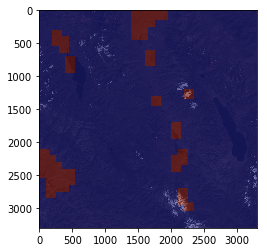

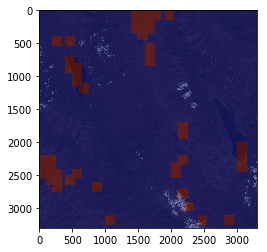

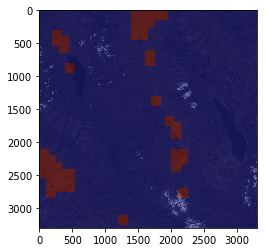

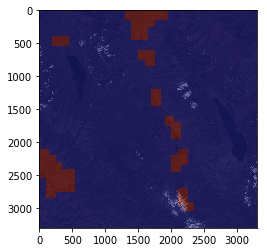

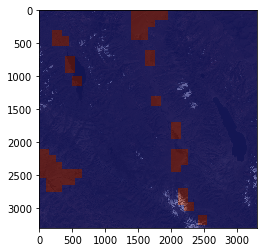

In [8]:
for im in res:
    plt.imshow(np.array(im))
    plt.show()

## apply for testing on a different region

In [4]:
data_preprocessor_muga_puruo = DataPreprocessor(data_dir="data/Region 2 - Muga Puruo/",
                              backend=dataiobackend,
                              filename_prefix="mpgr",
                              mode=Mode.TEST,
                              seed=1)

Driver: GTiff/GeoTIFF
Size is 3333 x 3333 x 1
Projection is PROJCS["WGS 84 / UTM zone 46N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32646"]]
Origin = (175000.0, 3899990.0)
Pixel Size = (30.0, -30.0)


In [5]:
data_preprocessor_muga_puruo.normalise()

In [8]:
res_muga_puruo = trainer.apply_for_sliding_window(data_preprocessor_muga_puruo, stride=10, max_output_size=50)

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 17.54it/s]
5it [00:00, 20.16it/s]
8it [00:00, 20.97it/s]
11it [00:00, 21.62it/s]
14it [00:00, 21.92it/s]
17it [00:00, 22.11it/s]
20it [00:00, 22.17it/s]
23it [00:01, 22.33it/s]
26it [00:01, 22.26it/s]
29it [00:01, 22.15it/s]
32it [00:01, 22.17it/s]
35it [00:01, 22.28it/s]
38it [00:01, 22.40it/s]
41it [00:01, 22.51it/s]
44it [00:01, 22.61it/s]
47it [00:02, 22.61it/s]
50it [00:02, 22.71it/s]
53it [00:02, 22.77it/s]
56it [00:02, 22.78it/s]
59it [00:02, 22.71it/s]
62it [00:02, 22.73it/s]
65it [00:02, 22.66it/s]
68it [00:03, 22.56it/s]
71it [00:03, 22.53it/s]
74it [00:03, 22.47it/s]
77it [00:03, 22.33it/s]
80it [00:03, 22.24it/s]
83it [00:03, 22.17it/s]
86it [00:03, 22.12it/s]
89it [00:04, 22.06it/s]
92it [00:04, 22.11it/s]
95it [00:04, 22.17it/s]
98it [00:04, 22.23it/s]
101it [00:04, 22.27it/s]
104it [00:04, 22.31it/s]
107it [00:04, 22.34it/s]
110it [00:04, 22.38it/s]
113it [00:05, 22.43it/s]
116it [00:05, 22.47it/s]
119i

875it [00:36, 23.90it/s]
878it [00:36, 23.91it/s]
881it [00:36, 23.91it/s]
884it [00:36, 23.91it/s]
887it [00:37, 23.91it/s]
890it [00:37, 23.92it/s]
893it [00:37, 23.92it/s]
896it [00:37, 23.92it/s]
899it [00:37, 23.92it/s]
902it [00:37, 23.93it/s]
905it [00:37, 23.93it/s]
908it [00:37, 23.93it/s]
911it [00:38, 23.93it/s]
914it [00:38, 23.94it/s]
917it [00:38, 23.94it/s]
920it [00:38, 23.94it/s]
923it [00:38, 23.94it/s]
926it [00:38, 23.94it/s]
929it [00:38, 23.95it/s]
932it [00:38, 23.95it/s]
935it [00:39, 23.95it/s]
938it [00:39, 23.95it/s]
941it [00:39, 23.95it/s]
944it [00:39, 23.96it/s]
947it [00:39, 23.96it/s]
950it [00:39, 23.96it/s]
953it [00:39, 23.96it/s]
956it [00:39, 23.96it/s]
959it [00:40, 23.97it/s]
962it [00:40, 23.97it/s]
965it [00:40, 23.97it/s]
968it [00:40, 23.97it/s]
971it [00:40, 23.97it/s]
974it [00:40, 23.97it/s]
977it [00:40, 23.98it/s]
980it [00:40, 23.98it/s]
983it [00:40, 23.98it/s]
986it [00:41, 23.98it/s]
989it [00:41, 23.98it/s]
992it [00:41, 23.98it/s]


box: [[1300, 2800, 1450, 2950]]
box: [[1300, 2900, 1450, 3050]]
box: [[1000, 500, 1150, 650]]
box: [[1300, 2700, 1450, 2850]]
box: [[1700, 2900, 1850, 3050]]
box: [[1300, 3000, 1450, 3150]]
box: [[1200, 2800, 1350, 2950]]
box: [[1700, 3000, 1850, 3150]]
box: [[1400, 2700, 1550, 2850]]
box: [[1200, 2700, 1350, 2850]]
box: [[1300, 2600, 1450, 2750]]
box: [[1200, 2900, 1350, 3050]]
box: [[1200, 3000, 1350, 3150]]
box: [[1200, 2500, 1350, 2650]]
box: [[1700, 2800, 1850, 2950]]
box: [[1200, 2600, 1350, 2750]]
box: [[1600, 2900, 1750, 3050]]
box: [[1600, 2700, 1750, 2850]]
box: [[0, 3000, 150, 3150]]
box: [[1100, 2700, 1250, 2850]]
box: [[1600, 2800, 1750, 2950]]
box: [[1400, 2800, 1550, 2950]]
box: [[0, 2900, 150, 3050]]
box: [[1200, 3100, 1350, 3250]]
box: [[1100, 2600, 1250, 2750]]
box: [[1600, 3000, 1750, 3150]]
box: [[0, 2800, 150, 2950]]
box: [[0, 2500, 150, 2650]]
box: [[1400, 2600, 1550, 2750]]
box: [[0, 2600, 150, 2750]]
box: [[1300, 2500, 1450, 2650]]
box: [[1100, 2800, 1250, 2950]

 20%|██        | 1/5 [00:44<02:56, 44.22s/it]
0it [00:00, ?it/s]
2it [00:00, 18.74it/s]
5it [00:00, 21.76it/s]
8it [00:00, 22.93it/s]
11it [00:00, 23.25it/s]
14it [00:00, 23.55it/s]
17it [00:00, 23.78it/s]
20it [00:00, 23.94it/s]
23it [00:00, 24.03it/s]
26it [00:01, 24.09it/s]
29it [00:01, 24.17it/s]
32it [00:01, 24.18it/s]
35it [00:01, 24.18it/s]
38it [00:01, 24.18it/s]
41it [00:01, 24.26it/s]
44it [00:01, 24.30it/s]
47it [00:01, 24.27it/s]
50it [00:02, 24.32it/s]
53it [00:02, 24.33it/s]
56it [00:02, 24.35it/s]
59it [00:02, 24.37it/s]
62it [00:02, 24.40it/s]
65it [00:02, 24.43it/s]
68it [00:02, 24.45it/s]
71it [00:02, 24.45it/s]
74it [00:03, 24.43it/s]
77it [00:03, 24.44it/s]
80it [00:03, 24.45it/s]
83it [00:03, 24.45it/s]
86it [00:03, 24.46it/s]
89it [00:03, 24.48it/s]
92it [00:03, 24.50it/s]
95it [00:03, 24.51it/s]
98it [00:03, 24.53it/s]
101it [00:04, 24.53it/s]
104it [00:04, 24.54it/s]
107it [00:04, 24.54it/s]
110it [00:04, 24.53it/s]
113it [00:04, 24.54it/s]
116it [00:04, 24.51it

875it [00:35, 24.51it/s]
878it [00:35, 24.52it/s]
881it [00:35, 24.52it/s]
884it [00:36, 24.51it/s]
887it [00:36, 24.51it/s]
890it [00:36, 24.51it/s]
893it [00:36, 24.51it/s]
896it [00:36, 24.51it/s]
899it [00:36, 24.51it/s]
902it [00:36, 24.51it/s]
905it [00:36, 24.51it/s]
908it [00:37, 24.51it/s]
911it [00:37, 24.51it/s]
914it [00:37, 24.51it/s]
917it [00:37, 24.51it/s]
920it [00:37, 24.51it/s]
923it [00:37, 24.51it/s]
926it [00:37, 24.51it/s]
929it [00:37, 24.51it/s]
932it [00:38, 24.51it/s]
935it [00:38, 24.51it/s]
938it [00:38, 24.51it/s]
941it [00:38, 24.51it/s]
944it [00:38, 24.51it/s]
947it [00:38, 24.51it/s]
950it [00:38, 24.52it/s]
953it [00:38, 24.52it/s]
956it [00:38, 24.51it/s]
959it [00:39, 24.52it/s]
962it [00:39, 24.52it/s]
965it [00:39, 24.52it/s]
968it [00:39, 24.52it/s]
971it [00:39, 24.52it/s]
974it [00:39, 24.52it/s]
977it [00:39, 24.52it/s]
980it [00:39, 24.52it/s]
983it [00:40, 24.52it/s]
986it [00:40, 24.52it/s]
989it [00:40, 24.52it/s]
992it [00:40, 24.52it/s]


box: [[1400, 2800, 1550, 2950]]
box: [[1300, 3000, 1450, 3150]]
box: [[0, 3000, 150, 3150]]
box: [[1700, 3000, 1850, 3150]]
box: [[1300, 3100, 1450, 3250]]
box: [[1400, 2900, 1550, 3050]]
box: [[1500, 600, 1650, 750]]
box: [[1900, 3000, 2050, 3150]]
box: [[1200, 2500, 1350, 2650]]
box: [[1600, 3100, 1750, 3250]]
box: [[200, 2800, 350, 2950]]
box: [[1100, 2700, 1250, 2850]]
box: [[1700, 2900, 1850, 3050]]
box: [[1100, 2900, 1250, 3050]]
box: [[1300, 2900, 1450, 3050]]
box: [[100, 2800, 250, 2950]]
box: [[1600, 3000, 1750, 3150]]
box: [[1200, 3000, 1350, 3150]]
box: [[100, 2300, 250, 2450]]
box: [[100, 3000, 250, 3150]]
box: [[1200, 2900, 1350, 3050]]
box: [[1200, 2700, 1350, 2850]]
box: [[100, 2900, 250, 3050]]
box: [[1200, 3100, 1350, 3250]]
box: [[1200, 2800, 1350, 2950]]
box: [[0, 2600, 150, 2750]]
box: [[100, 2700, 250, 2850]]
box: [[200, 2400, 350, 2550]]
box: [[1300, 2800, 1450, 2950]]
box: [[1300, 2700, 1450, 2850]]
box: [[1400, 2700, 1550, 2850]]
box: [[800, 2000, 950, 2150]]
bo

 40%|████      | 2/5 [01:27<02:11, 43.74s/it]
0it [00:00, ?it/s]
2it [00:00, 17.58it/s]
5it [00:00, 20.75it/s]
8it [00:00, 22.22it/s]
11it [00:00, 22.88it/s]
14it [00:00, 23.37it/s]
17it [00:00, 23.71it/s]
20it [00:00, 23.86it/s]
23it [00:00, 24.06it/s]
26it [00:01, 24.18it/s]
29it [00:01, 24.28it/s]
32it [00:01, 24.35it/s]
35it [00:01, 24.42it/s]
38it [00:01, 24.48it/s]
41it [00:01, 24.47it/s]
44it [00:01, 24.49it/s]
47it [00:01, 24.53it/s]
50it [00:02, 24.55it/s]
53it [00:02, 24.60it/s]
56it [00:02, 24.57it/s]
59it [00:02, 24.60it/s]
62it [00:02, 24.65it/s]
65it [00:02, 24.67it/s]
68it [00:02, 24.67it/s]
71it [00:02, 24.70it/s]
74it [00:02, 24.70it/s]
77it [00:03, 24.73it/s]
80it [00:03, 24.72it/s]
83it [00:03, 24.70it/s]
86it [00:03, 24.72it/s]
89it [00:03, 24.73it/s]
92it [00:03, 24.74it/s]
95it [00:03, 24.75it/s]
98it [00:03, 24.76it/s]
101it [00:04, 24.77it/s]
104it [00:04, 24.78it/s]
107it [00:04, 24.80it/s]
110it [00:04, 24.81it/s]
113it [00:04, 24.81it/s]
116it [00:04, 24.81it

875it [00:35, 24.78it/s]
878it [00:35, 24.79it/s]
881it [00:35, 24.78it/s]
884it [00:35, 24.78it/s]
887it [00:35, 24.78it/s]
890it [00:35, 24.78it/s]
893it [00:36, 24.78it/s]
896it [00:36, 24.78it/s]
899it [00:36, 24.78it/s]
902it [00:36, 24.79it/s]
905it [00:36, 24.79it/s]
908it [00:36, 24.78it/s]
911it [00:36, 24.78it/s]
914it [00:36, 24.79it/s]
917it [00:36, 24.79it/s]
920it [00:37, 24.79it/s]
923it [00:37, 24.79it/s]
926it [00:37, 24.79it/s]
929it [00:37, 24.79it/s]
932it [00:37, 24.79it/s]
935it [00:37, 24.79it/s]
938it [00:37, 24.79it/s]
941it [00:37, 24.79it/s]
944it [00:38, 24.79it/s]
947it [00:38, 24.79it/s]
950it [00:38, 24.79it/s]
953it [00:38, 24.79it/s]
956it [00:38, 24.79it/s]
959it [00:38, 24.79it/s]
962it [00:38, 24.80it/s]
965it [00:38, 24.79it/s]
968it [00:39, 24.80it/s]
971it [00:39, 24.80it/s]
974it [00:39, 24.80it/s]
977it [00:39, 24.80it/s]
980it [00:39, 24.80it/s]
983it [00:39, 24.80it/s]
986it [00:39, 24.80it/s]
989it [00:39, 24.80it/s]
992it [00:40, 24.80it/s]


box: [[1700, 2900, 1850, 3050]]
box: [[1300, 2900, 1450, 3050]]
box: [[1200, 2800, 1350, 2950]]
box: [[1700, 3000, 1850, 3150]]
box: [[1200, 2700, 1350, 2850]]
box: [[1300, 2700, 1450, 2850]]
box: [[1300, 2800, 1450, 2950]]
box: [[1300, 2600, 1450, 2750]]
box: [[1300, 3000, 1450, 3150]]
box: [[1200, 2900, 1350, 3050]]
box: [[1200, 3000, 1350, 3150]]
box: [[1200, 2600, 1350, 2750]]
box: [[1600, 2900, 1750, 3050]]
box: [[1600, 2800, 1750, 2950]]
box: [[1200, 2500, 1350, 2650]]
box: [[1600, 2700, 1750, 2850]]
box: [[0, 2900, 150, 3050]]
box: [[1100, 2700, 1250, 2850]]
box: [[1700, 2800, 1850, 2950]]
box: [[0, 3000, 150, 3150]]
box: [[0, 2800, 150, 2950]]
box: [[0, 2500, 150, 2650]]
box: [[0, 2600, 150, 2750]]
box: [[1400, 2700, 1550, 2850]]
box: [[0, 2700, 150, 2850]]
box: [[100, 2800, 250, 2950]]
box: [[1100, 2600, 1250, 2750]]
box: [[1100, 2800, 1250, 2950]]
box: [[1200, 3100, 1350, 3250]]
box: [[100, 2600, 250, 2750]]
box: [[1600, 3000, 1750, 3150]]
box: [[100, 2700, 250, 2850]]
box: [

 60%|██████    | 3/5 [02:10<01:26, 43.45s/it]
0it [00:00, ?it/s]
2it [00:00, 16.72it/s]
5it [00:00, 20.81it/s]
8it [00:00, 22.23it/s]
11it [00:00, 22.93it/s]
14it [00:00, 23.28it/s]
17it [00:00, 23.47it/s]
20it [00:00, 23.61it/s]
23it [00:00, 23.78it/s]
26it [00:01, 23.93it/s]
29it [00:01, 24.00it/s]
32it [00:01, 24.04it/s]
35it [00:01, 24.16it/s]
38it [00:01, 24.19it/s]
41it [00:01, 24.26it/s]
44it [00:01, 24.30it/s]
47it [00:01, 24.32it/s]
50it [00:02, 24.31it/s]
53it [00:02, 24.33it/s]
56it [00:02, 24.38it/s]
59it [00:02, 24.39it/s]
62it [00:02, 24.35it/s]
65it [00:02, 24.38it/s]
68it [00:02, 24.40it/s]
71it [00:02, 24.37it/s]
74it [00:03, 24.33it/s]
77it [00:03, 24.35it/s]
80it [00:03, 24.37it/s]
83it [00:03, 24.39it/s]
86it [00:03, 24.39it/s]
89it [00:03, 24.38it/s]
92it [00:03, 24.38it/s]
95it [00:03, 24.38it/s]
98it [00:04, 24.38it/s]
101it [00:04, 24.41it/s]
104it [00:04, 24.41it/s]
107it [00:04, 24.43it/s]
110it [00:04, 24.43it/s]
113it [00:04, 24.44it/s]
116it [00:04, 24.44it

875it [00:35, 24.57it/s]
878it [00:35, 24.57it/s]
881it [00:35, 24.57it/s]
884it [00:35, 24.57it/s]
887it [00:36, 24.57it/s]
890it [00:36, 24.57it/s]
893it [00:36, 24.57it/s]
896it [00:36, 24.57it/s]
899it [00:36, 24.57it/s]
902it [00:36, 24.58it/s]
905it [00:36, 24.58it/s]
908it [00:36, 24.57it/s]
911it [00:37, 24.58it/s]
914it [00:37, 24.58it/s]
917it [00:37, 24.57it/s]
920it [00:37, 24.57it/s]
923it [00:37, 24.58it/s]
926it [00:37, 24.58it/s]
929it [00:37, 24.58it/s]
932it [00:37, 24.58it/s]
935it [00:38, 24.58it/s]
938it [00:38, 24.58it/s]
941it [00:38, 24.57it/s]
944it [00:38, 24.57it/s]
947it [00:38, 24.57it/s]
950it [00:38, 24.57it/s]
953it [00:38, 24.57it/s]
956it [00:38, 24.57it/s]
959it [00:39, 24.57it/s]
962it [00:39, 24.57it/s]
965it [00:39, 24.57it/s]
968it [00:39, 24.57it/s]
971it [00:39, 24.57it/s]
974it [00:39, 24.57it/s]
977it [00:39, 24.57it/s]
980it [00:39, 24.57it/s]
983it [00:40, 24.57it/s]
986it [00:40, 24.57it/s]
989it [00:40, 24.56it/s]
992it [00:40, 24.56it/s]


box: [[1300, 2800, 1450, 2950]]
box: [[1300, 2700, 1450, 2850]]
box: [[1300, 2900, 1450, 3050]]
box: [[1700, 2900, 1850, 3050]]
box: [[1200, 2800, 1350, 2950]]
box: [[1300, 2600, 1450, 2750]]
box: [[1400, 2700, 1550, 2850]]
box: [[1200, 2700, 1350, 2850]]
box: [[1300, 3000, 1450, 3150]]
box: [[1700, 3000, 1850, 3150]]
box: [[1200, 2600, 1350, 2750]]
box: [[1200, 3000, 1350, 3150]]
box: [[1700, 2800, 1850, 2950]]
box: [[1200, 2500, 1350, 2650]]
box: [[1200, 2900, 1350, 3050]]
box: [[1600, 2800, 1750, 2950]]
box: [[1600, 2900, 1750, 3050]]
box: [[1600, 2700, 1750, 2850]]
box: [[1100, 2700, 1250, 2850]]
box: [[0, 2900, 150, 3050]]
box: [[0, 3000, 150, 3150]]
box: [[1400, 2800, 1550, 2950]]
box: [[1400, 2600, 1550, 2750]]
box: [[0, 2800, 150, 2950]]
box: [[1300, 2500, 1450, 2650]]
box: [[1100, 2600, 1250, 2750]]
box: [[0, 2500, 150, 2650]]
box: [[1100, 2800, 1250, 2950]]
box: [[1200, 3100, 1350, 3250]]
box: [[100, 2800, 250, 2950]]
box: [[0, 2600, 150, 2750]]
box: [[100, 2600, 250, 2750]]


 80%|████████  | 4/5 [02:53<00:43, 43.40s/it]
0it [00:00, ?it/s]
2it [00:00, 15.20it/s]
5it [00:00, 19.63it/s]
8it [00:00, 21.28it/s]
11it [00:00, 21.89it/s]
14it [00:00, 22.36it/s]
17it [00:00, 22.66it/s]
20it [00:00, 22.87it/s]
23it [00:00, 23.09it/s]
26it [00:01, 23.13it/s]
29it [00:01, 23.22it/s]
32it [00:01, 23.36it/s]
35it [00:01, 23.46it/s]
38it [00:01, 23.51it/s]
41it [00:01, 23.57it/s]
44it [00:01, 23.61it/s]
47it [00:01, 23.56it/s]
50it [00:02, 23.60it/s]
53it [00:02, 23.62it/s]
56it [00:02, 23.64it/s]
59it [00:02, 23.69it/s]
62it [00:02, 23.74it/s]
65it [00:02, 23.76it/s]
68it [00:02, 23.79it/s]
71it [00:02, 23.80it/s]
74it [00:03, 23.81it/s]
77it [00:03, 23.80it/s]
80it [00:03, 23.84it/s]
83it [00:03, 23.85it/s]
86it [00:03, 23.87it/s]
89it [00:03, 23.92it/s]
92it [00:03, 23.94it/s]
95it [00:03, 23.96it/s]
98it [00:04, 23.97it/s]
101it [00:04, 23.96it/s]
104it [00:04, 23.95it/s]
107it [00:04, 23.97it/s]
110it [00:04, 23.97it/s]
113it [00:04, 23.98it/s]
116it [00:04, 23.99it

875it [00:35, 24.32it/s]
878it [00:36, 24.33it/s]
881it [00:36, 24.33it/s]
884it [00:36, 24.32it/s]
887it [00:36, 24.33it/s]
890it [00:36, 24.33it/s]
893it [00:36, 24.33it/s]
896it [00:36, 24.33it/s]
899it [00:36, 24.33it/s]
902it [00:37, 24.33it/s]
905it [00:37, 24.33it/s]
908it [00:37, 24.33it/s]
911it [00:37, 24.33it/s]
914it [00:37, 24.33it/s]
917it [00:37, 24.32it/s]
920it [00:37, 24.32it/s]
923it [00:37, 24.32it/s]
926it [00:38, 24.32it/s]
929it [00:38, 24.32it/s]
932it [00:38, 24.32it/s]
935it [00:38, 24.32it/s]
938it [00:38, 24.32it/s]
941it [00:38, 24.32it/s]
944it [00:38, 24.32it/s]
947it [00:38, 24.32it/s]
950it [00:39, 24.32it/s]
953it [00:39, 24.32it/s]
956it [00:39, 24.32it/s]
959it [00:39, 24.32it/s]
962it [00:39, 24.32it/s]
965it [00:39, 24.32it/s]
968it [00:39, 24.32it/s]
971it [00:39, 24.32it/s]
974it [00:40, 24.32it/s]
977it [00:40, 24.32it/s]
980it [00:40, 24.32it/s]
983it [00:40, 24.32it/s]
986it [00:40, 24.32it/s]
989it [00:40, 24.32it/s]
992it [00:40, 24.32it/s]


box: [[1300, 2900, 1450, 3050]]
box: [[1700, 2900, 1850, 3050]]
box: [[1300, 3000, 1450, 3150]]
box: [[1300, 2800, 1450, 2950]]
box: [[1300, 2700, 1450, 2850]]
box: [[1700, 3000, 1850, 3150]]
box: [[1200, 2800, 1350, 2950]]
box: [[1200, 2900, 1350, 3050]]
box: [[1200, 2700, 1350, 2850]]
box: [[0, 3000, 150, 3150]]
box: [[1200, 3000, 1350, 3150]]
box: [[1400, 2700, 1550, 2850]]
box: [[1300, 2600, 1450, 2750]]
box: [[1200, 2500, 1350, 2650]]
box: [[1600, 3000, 1750, 3150]]
box: [[1600, 2900, 1750, 3050]]
box: [[1400, 2800, 1550, 2950]]
box: [[1200, 2600, 1350, 2750]]
box: [[1200, 3100, 1350, 3250]]
box: [[1100, 2700, 1250, 2850]]
box: [[1600, 2700, 1750, 2850]]
box: [[1600, 2800, 1750, 2950]]
box: [[1000, 500, 1150, 650]]
box: [[1700, 2800, 1850, 2950]]
box: [[1100, 2800, 1250, 2950]]
box: [[1100, 2600, 1250, 2750]]
box: [[0, 2600, 150, 2750]]
box: [[0, 2900, 150, 3050]]
box: [[1100, 2900, 1250, 3050]]
box: [[0, 2500, 150, 2650]]
box: [[0, 2800, 150, 2950]]
box: [[1700, 3100, 1850, 3250]

100%|██████████| 5/5 [03:37<00:00, 43.45s/it]


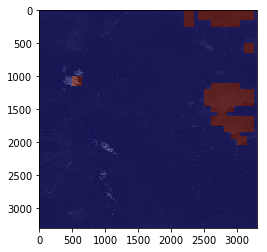

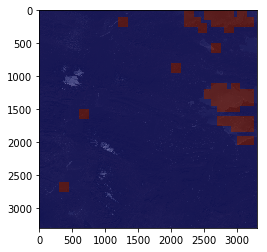

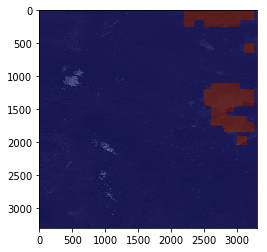

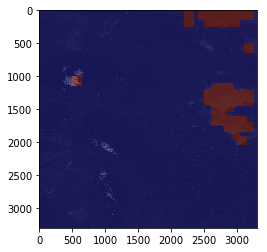

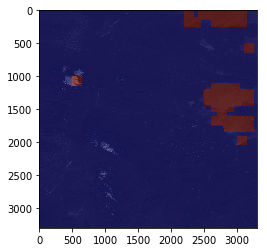

In [10]:
for im in res_muga_puruo:
    plt.imshow(np.array(im))
    plt.show()